# Risk-Averse RL in the Servers Allocation Problem

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import gym
import ServersSim
import ServersLab as SL
import Agents
import utils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

In [2]:
# Whether to load existing results or train new agents
LOAD_ONLY = True

## The Servers Allocation benchmark

Sample episodes of a neutral agent and a random agent:

Wall time: 2.43 s


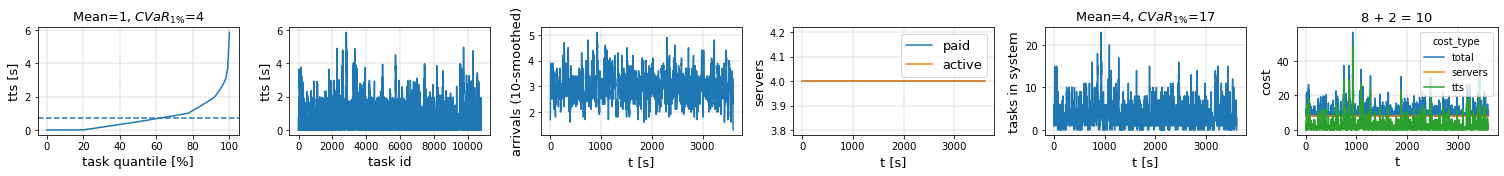

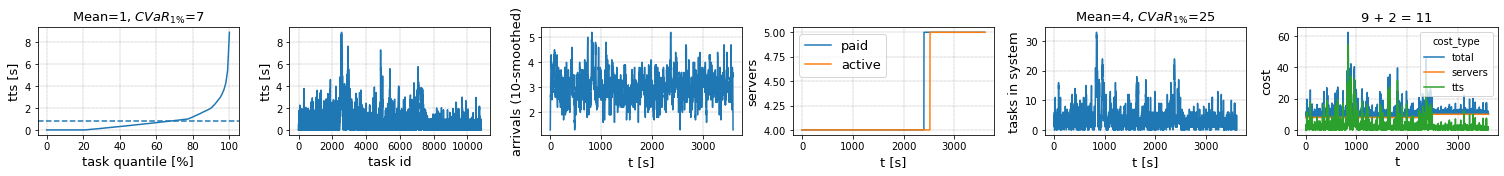

In [3]:
%%time

# Make sure the environment is registered
if 'ServersSim-v0' in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs['ServersSim-v0']
gym.envs.registration.register(id='ServersSim-v0', entry_point='ServersSim:ServersSim')
env = gym.make('ServersSim-v0')

# Run episode (neutral actions)
env.reset()
done = False
while not done:
    obs, r, done, info = env.step(0)
env.analyze_episode()

# Run episode (random actions)
env.reset()
done = False
while not done:
    obs, r, done, info = env.step(np.random.choice((0,1,2), p=(0.96,0.02,0.02)))
env.analyze_episode()

env.close()

## CE for risk-averse RL in Servers Allocation

In [4]:
%%time

title = 'ServersAllocation'
experiment_args = dict(title=title)

# Define agents (note that the training hyperparams are also defined here through the dict train_hparams)
agents = dict(
    PG = (Agents.FC, dict()),
    GCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.01))),
    CeSoR = (Agents.FC, dict(train_hparams=dict(cvar=0.01, ce_update_freq=1, soft_cvar=0.8, ce_n_orig=0.5))),
);

# Run experiment
E = SL.Experiment(agents, train_episodes=40000, **experiment_args)
if LOAD_ONLY:
    E.load_results(agents=True, optimizers=True, CEs=True)
else:
    E.train()
    E.test()
    E.save_results()

E.dd

Wall time: 5.46 s


,agent,group,episode,ag_updates,ag_hash,ag_temperature,prior_freq,n_events,L,log_prob,ret_loss,score,opt_selected,ce_selected,weight
0,PG,train,0,0,0x35c0737751b8a22d,1,0.000004,0,900,-17.967566,-28.354477,-12.944718,1.0,NaN,NaN
1,PG,train,1,0,0x35c0737751b8a22d,1,0.000004,0,900,-16.678373,-29.252758,-11.864239,1.0,NaN,NaN
2,PG,train,2,0,0x35c0737751b8a22d,1,0.000004,0,900,-17.419081,-41.570854,-17.716592,1.0,NaN,NaN
3,PG,train,3,0,0x35c0737751b8a22d,1,0.000004,0,900,-17.774506,-37.456699,-15.172713,1.0,NaN,NaN
4,PG,train,4,0,0x35c0737751b8a22d,1,0.000004,0,900,-17.744078,-183.374359,-80.548719,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123595,CeSoR,test,1195,100,0x968e9abb523f345,0,0.000004,0,3600,-15.873078,-3.426864,-11.362577,NaN,NaN,NaN
123596,CeSoR,test,1196,100,0x968e9abb523f345,0,0.000004,0,3600,-15.807177,-3.386989,-11.230363,NaN,NaN,NaN
123597,CeSoR,test,1197,100,0x968e9abb523f345,0,0.000004,0,3600,-16.042728,-3.402962,-11.283324,NaN,NaN,NaN
123598,CeSoR,test,1198,100,0x968e9abb523f345,0,0.000004,0,3600,-15.852165,-3.398976,-11.270108,NaN,NaN,NaN


### Experiment analysis

PG (70/100):	mean=-10.5	CVaR05=-14.4	CVaR01=-27.4
GCVaR (100/100):	mean=-16.9	CVaR05=-17.1	CVaR01=-17.7
CeSoR (60/100):	mean=-11.3	CVaR05=-12.2	CVaR01=-14.9
Wall time: 7.26 s


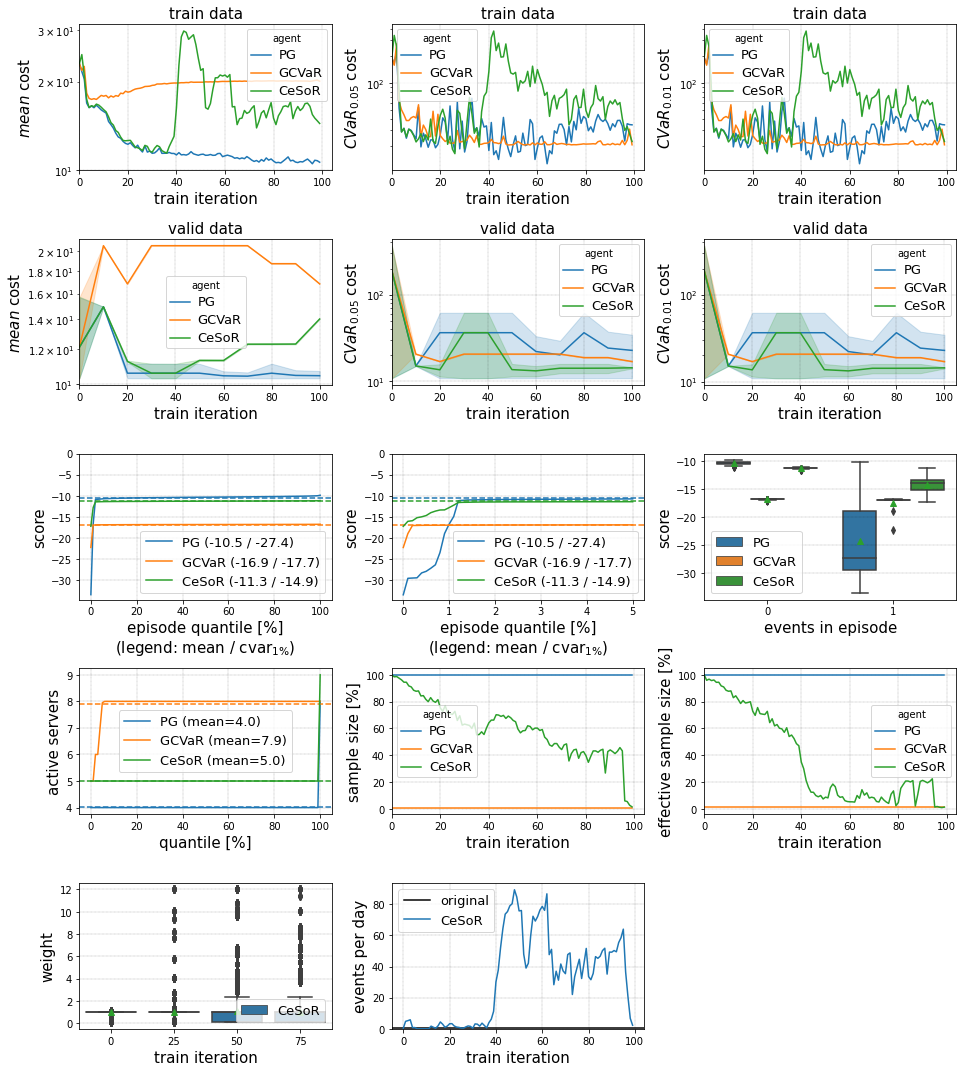

In [5]:
%%time
axs = E.analyze()
plt.savefig(f'outputs/{experiment_args["title"]}_summary.png', bbox_inches='tight');

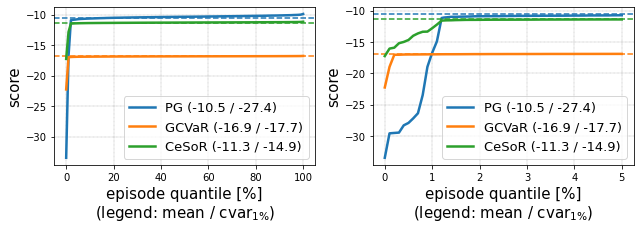

In [6]:
test_df = E.dd[E.dd.group=='test']
axs = utils.Axes(2, 2, (4.5,3.3), fontsize=15)
a = 0

n_iters = E.n_train // E.optim_freq
cvar = lambda x, alpha: np.mean(np.sort(x)[:int(np.ceil(alpha*len(x)))])
for Q in (100, 5):
    for agent in E.agents_names:
        scores = test_df.score[test_df.agent==agent].values
        utils.plot_quantiles(
            scores, q=np.linspace(0,Q,101)/100, ax=axs[a], linewidth=2.5, showmeans=True,
            label=f'{agent} ({np.mean(scores):.1f} / {cvar(scores, 0.01):.1f})')
    # axs[a].set_ylim((-250,None))
    axs.labs(a, 'episode quantile [%]\n(legend: mean / cvar$_{1\%}$)', 'score')
    axs[a].legend(fontsize=13)
    a += 1
plt.tight_layout()
plt.savefig(f'outputs/{title}_test.png', bbox_inches='tight');

CE distribution over training:

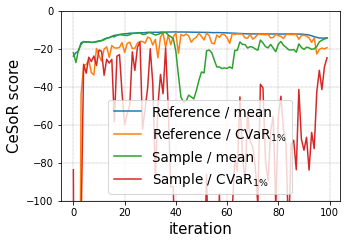

In [7]:
ax = E.CEs['CeSoR'].show_sampled_scores(None, 'CeSoR score')
ax.set_ylim((-100,0))
ax.legend(loc='lower center', fontsize=13.5)
plt.savefig(f'outputs/{title}_CE.png', bbox_inches='tight');

A sample of test episodes:

Wall time: 25 s


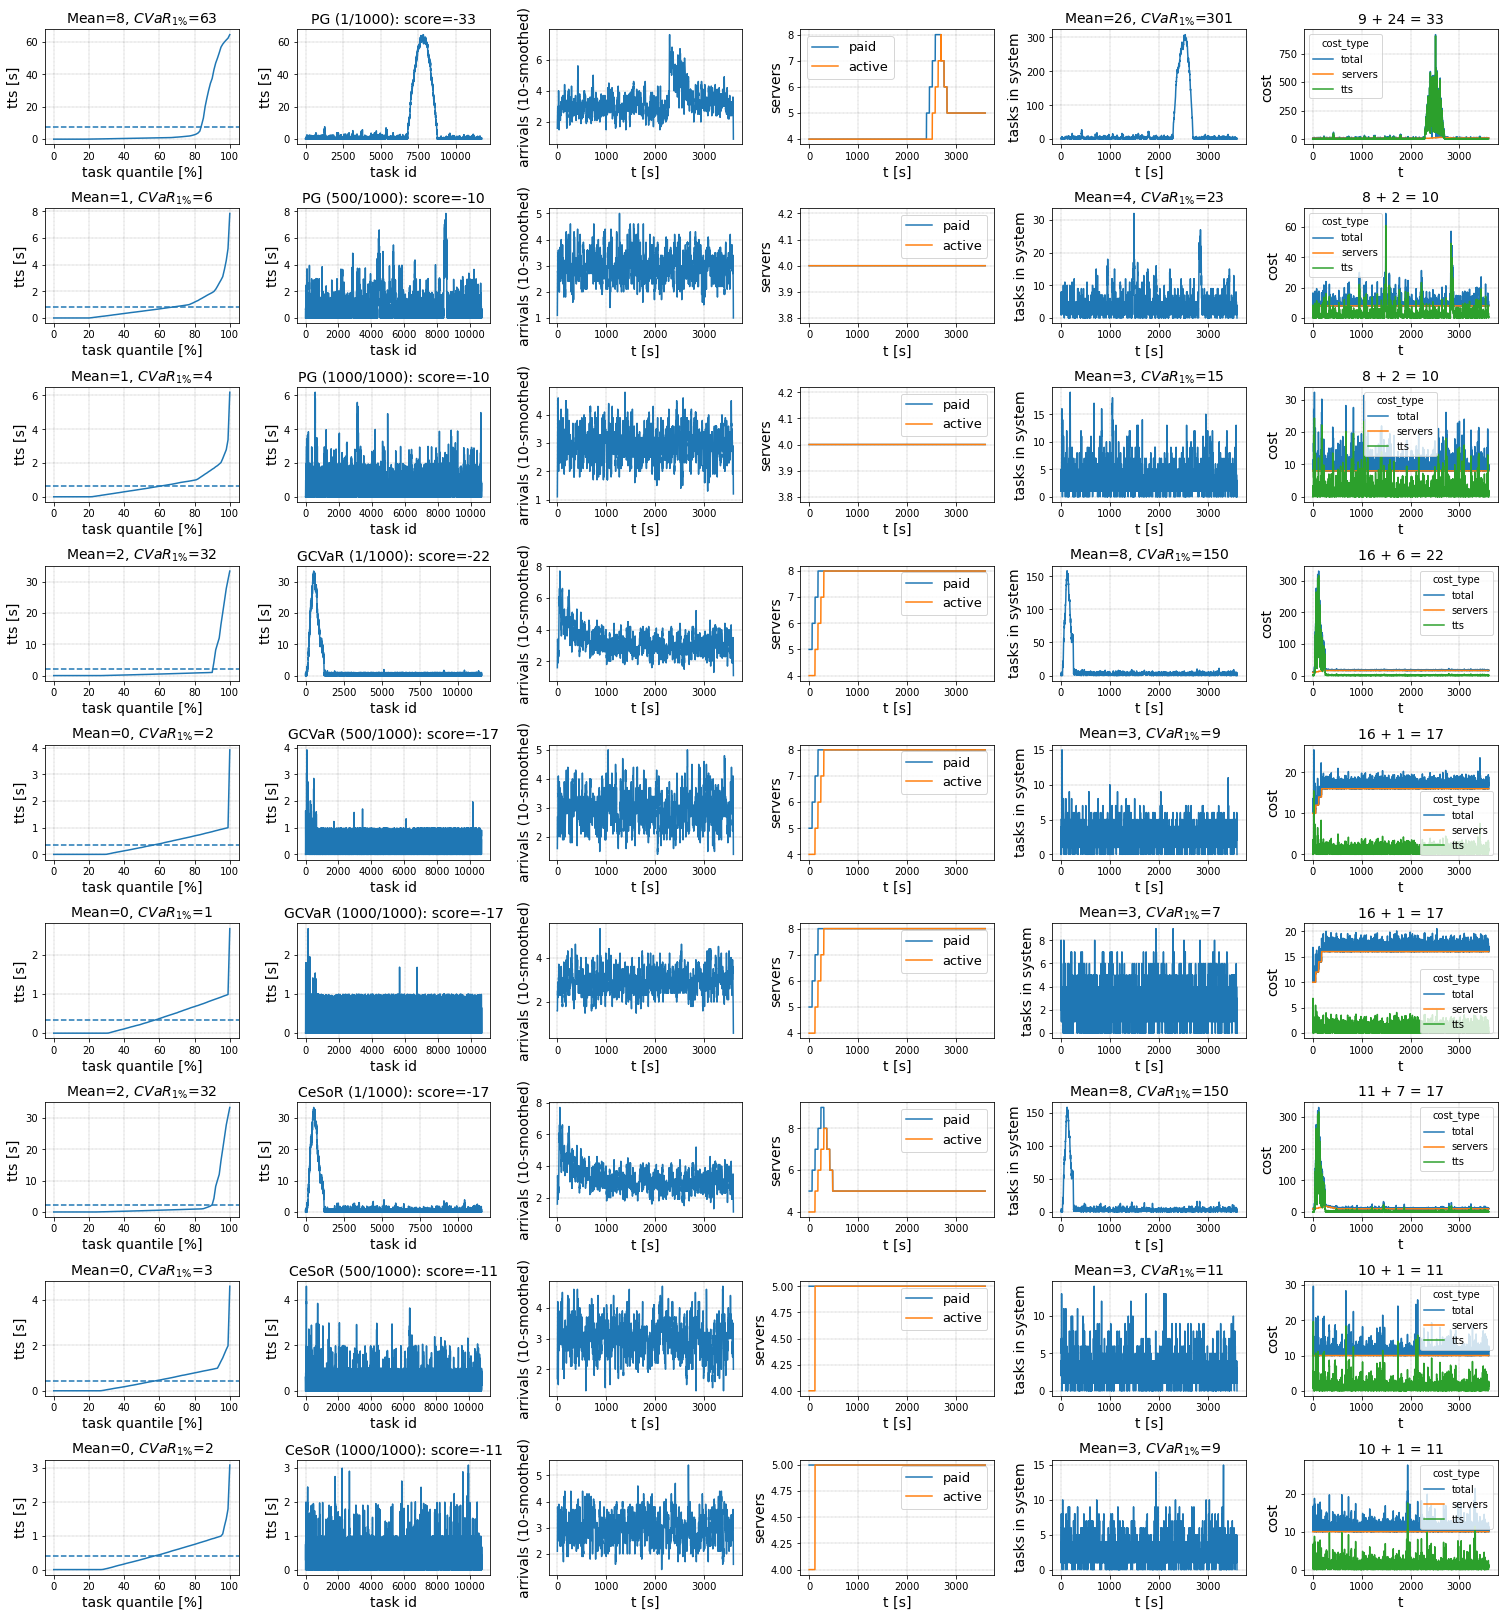

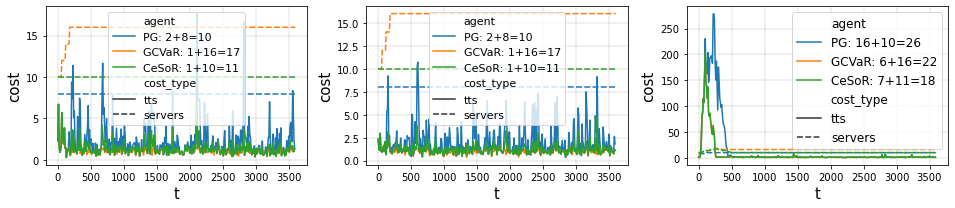

In [8]:
%%time
axs1, axs2 = E.show_tests()
axs2[0].legend(fontsize=11, loc='upper center')
axs2[1].legend(fontsize=11, loc='upper center')
plt.savefig(f'outputs/{title}_examples.png', bbox_inches='tight');

Bad test episodes:

In [9]:
d = E.dd
d[(d.group=='test')&(d.score<-20)]

,agent,group,episode,ag_updates,ag_hash,ag_temperature,prior_freq,n_events,L,log_prob,ret_loss,score,opt_selected,ce_selected,weight
120319,PG,test,319,100,-0x61b97fc150fd500b,0,0.000004,1,3600,-2.589632,-0.544029,-23.461162,NaN,NaN,NaN
120527,PG,test,527,100,-0x61b97fc150fd500b,0,0.000004,1,3600,-4.014306,-7.120098,-27.923565,NaN,NaN,NaN
120676,PG,test,676,100,-0x61b97fc150fd500b,0,0.000004,1,3600,-3.426244,-0.776568,-33.489368,NaN,NaN,NaN
120756,PG,test,756,100,-0x61b97fc150fd500b,0,0.000004,1,3600,-3.353508,-0.656334,-28.304262,NaN,NaN,NaN
120799,PG,test,799,100,-0x61b97fc150fd500b,0,0.000004,1,3600,-2.475079,-0.611597,-26.375004,NaN,NaN,NaN
120826,PG,test,826,100,-0x61b97fc150fd500b,0,0.000004,1,3600,-2.945156,-0.686005,-29.583848,NaN,NaN,NaN
120831,PG,test,831,100,-0x61b97fc150fd500b,0,0.000004,1,3600,-3.693114,-0.684603,-29.523360,NaN,NaN,NaN
120850,PG,test,850,100,-0x61b97fc150fd500b,0,0.000004,1,3600,-2.896399,-0.630614,-27.195127,NaN,NaN,NaN
120972,PG,test,972,100,-0x61b97fc150fd500b,0,0.000004,1,3600,-3.504610,-0.683285,-29.466544,NaN,NaN,NaN
121999,GCVaR,test,799,100,-0x73b801b104f66bdf,0,0.000004,1,3600,-40.742584,-17.368082,-22.269316,NaN,NaN,NaN


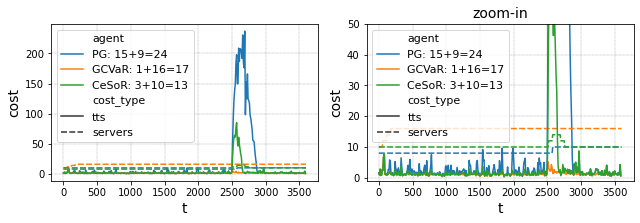

In [16]:
ep = 319
axs = utils.Axes(2,2,(4.5,3.2),fontsize=14)

E.analyze_episode(ep, axs=axs, a=0)
E.analyze_episode(ep, axs=axs, a=1)
axs[1].set_ylim((-1,50))
axs.labs(1, title='zoom-in')
plt.tight_layout()

plt.savefig(f'outputs/{experiment_args["title"]}_ep{ep:d}.png', bbox_inches='tight');